In [1]:
!pip install statsmodels
# test

In [2]:
!pip install geopandas

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import matplotlib.pyplot as plt

In [3]:
#import Pop_County
df_census2020 = pd.read_csv('DECENNIALPL2020.P1-2024-11-10T174624.csv')
df_population_bycounty = df_census2020.head(1)
df_population_bycounty.columns = df_population_bycounty.columns.str.replace(' County, California', '', regex=False)
county_names = df_population_bycounty.columns[1:]
populations = df_population_bycounty.iloc[0, 1:].replace(',', '', regex=True).astype(int)
df_population_bycounty = pd.DataFrame({
    'County': county_names,
    'Population': populations
}).reset_index(drop=True)
df_population_bycounty = df_population_bycounty.rename(columns={'County': 'CountyName'})
print(len(df_population_bycounty))
df_population_bycounty.head()
# county_names


58


,CountyName,Population
0,Alameda,1682353
1,Alpine,1204
2,Amador,40474
3,Butte,211632
4,Calaveras,45292


In [4]:
# import hospital data

# df_hospital = pd.read_csv('ed-volume-and-capacity-2021.csv', encoding = "ISO-8859-1", index_col=[0])
# df_hospital = df_hospital[df_hospital["Category"] == "Asthma"]
# df_hospital_bycounty = df_hospital.groupby('CountyName')['EDDXCount'].sum().reset_index()
# df_hospital_bycounty.head()

df_hospital = pd.read_csv('asthma-emergency-department-visit-rates-by-county-2015_2022.csv', encoding = "ISO-8859-1")
df_hospital_bycounty = df_hospital[df_hospital["STRATA NAME"] == "All ages"]
df_hospital_bycounty = df_hospital_bycounty[df_hospital_bycounty["YEAR"] <= 2019]
df_hospital_bycounty = df_hospital_bycounty.rename(columns={'COUNTY': 'CountyName'})
df_hospital_bycounty = df_hospital_bycounty[["CountyName", "YEAR", "AGE-ADJUSTED ED VISIT RATE"]]
df_hospital_bycounty = df_hospital_bycounty[df_hospital_bycounty["CountyName"] != "California"]
print(len(df_hospital_bycounty))
df_hospital_bycounty.head()

290


,CountyName,YEAR,AGE-ADJUSTED ED VISIT RATE
1,Alameda,2015,64.3
2,Alpine,2015,0.0
3,Amador,2015,58.4
4,Butte,2015,50.2
5,Calaveras,2015,48.0


In [5]:
df_hospital_pop_bycounty = pd.merge(df_population_bycounty, df_hospital_bycounty, on='CountyName', how='inner')
df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"] = df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"].replace({',': ''}, regex=True)
df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"] = pd.to_numeric(df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"])

df_hospital_pop_bycounty.rename(columns={'AGE-ADJUSTED ED VISIT RATE': 'VisitRate'}, inplace=True)

df_hospital_pop_bycounty = df_hospital_pop_bycounty.dropna()

# df_hospital_pop_bycounty["NormalizedVisits"] = df_hospital_pop_bycounty["NUMBER OF ED VISITS"] /  df_hospital_pop_bycounty["Population"] * 10000

df_hospital_pop_bycounty = df_hospital_pop_bycounty[df_hospital_pop_bycounty['VisitRate'] >= 1] # remove 1 outlier 

print(len(df_hospital_pop_bycounty))
df_hospital_pop_bycounty.head(n=6)

281


,CountyName,Population,YEAR,VisitRate
0,Alameda,1682353,2015,64.3
1,Alameda,1682353,2016,57.8
2,Alameda,1682353,2017,56.3
3,Alameda,1682353,2018,48.6
4,Alameda,1682353,2019,45.8
10,Amador,40474,2015,58.4


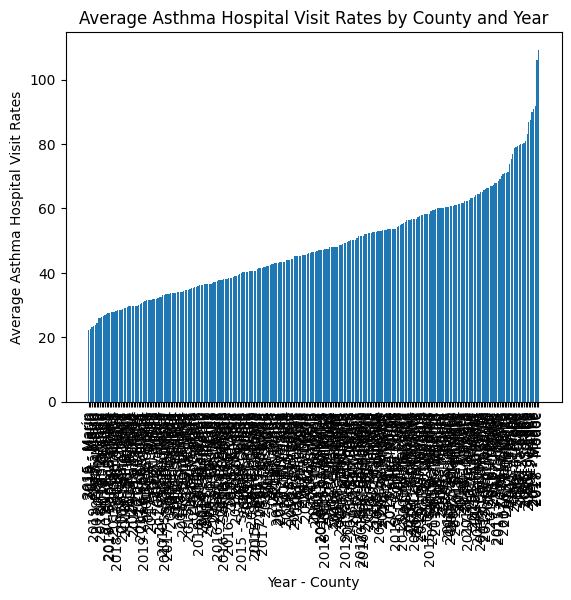

In [6]:
df_hospital_pop_bycounty['YearCounty'] = df_hospital_pop_bycounty['YEAR'].astype(str) + ' - ' + df_hospital_pop_bycounty['CountyName']
df_hospital_pop_bycounty_sorted = df_hospital_pop_bycounty.sort_values(by='VisitRate', ascending=True)
plt.bar(df_hospital_pop_bycounty_sorted['YearCounty'], df_hospital_pop_bycounty_sorted['VisitRate'])
plt.xticks(rotation=90)
plt.xlabel('Year - County')
plt.ylabel('Average Asthma Hospital Visit Rates')
plt.title('Average Asthma Hospital Visit Rates by County and Year')
plt.show()

In [7]:
# import matplotlib.pyplot as plt

# df_hospital_pop_bycounty_sorted = df_hospital_pop_bycounty.sort_values(by='NormalizedVisits', ascending=True)

# plt.bar(df_hospital_pop_bycounty_sorted['CountyName'], df_hospital_pop_bycounty_sorted['NormalizedVisits'])
# plt.xticks(range(df_hospital_pop_bycounty_sorted['CountyName'].shape[0]), df_hospital_pop_bycounty_sorted['CountyName'], rotation='vertical')
# plt.xlabel('County')
# plt.ylabel('Average Asthma Hospital Visits')
# plt.title('Average Asthma Hospital Visits by County')
# plt.show()

In [8]:
# Function to count number of days with aqi at or worse than 100
def make_aqi_df(csv_name, year):
    df_air = pd.read_csv(csv_name, encoding = "ISO-8859-1", index_col=[0])
    df_air = df_air.groupby('County')['Daily AQI Value'].apply(lambda x: (x >= 100).sum()).reset_index()
    df_air = df_air.rename(columns={'Daily AQI Value': 'days over 100'})
    df_air['Year'] = year
    return df_air[['County', 'Year', 'days over 100']]

In [9]:
# Function to calculate weighted sum of days with bad aqi
# 0-50: weight 0, 51-100: weight 1, 101-150: weight 2, 151-200 weight 3, 201-300 weight 4, >300: weight 5
def calc_weighted_sum(df):
        class_5 = (df['Daily AQI Value'] > 300).sum()
        class_4 = ((df['Daily AQI Value'] > 200) & (df['Daily AQI Value'] <= 300)).sum()
        class_3 = ((df['Daily AQI Value'] > 150) & (df['Daily AQI Value'] <= 200)).sum()
        class_2 = ((df['Daily AQI Value'] > 100) & (df['Daily AQI Value'] <= 150)).sum()
        class_1 = ((df['Daily AQI Value'] > 50) & (df['Daily AQI Value'] <= 100)).sum()

        weighted_sum = 5 * class_5 + 4 * class_4 + 3 * class_3 + 2 * class_2 + class_1
        return weighted_sum

In [27]:
# Function to make df with weighted aqi days from single year csv

def make_weighted_aqi_df(csv_name, year):
    df_air_preprocess = pd.read_csv(csv_name, encoding="ISO-8859-1", index_col=[0])
    number_of_sensors = len(df_air_preprocess['Site ID'].unique())
    num_missing_data = (number_of_sensors * 365 ) - len(df_air_preprocess)
    print("Missing ", num_missing_data, " of expected ", number_of_sensors * 365, "data points in year ", year)
    df_air_preprocess = df_air_preprocess[['County', 'Daily AQI Value', 'Site ID']]
    counties = df_air_preprocess['County'].unique()

    # count instances of different aqi values
    counts_df = pd.DataFrame(columns=['County', 'Weighted AQI Days'])
    county_sum = 0
    for county in counties:
        county_df = df_air_preprocess[df_air_preprocess['County'] == county]

        for sensor in county_df['Site ID'].unique():
            sensor_df = county_df[county_df['Site ID'] == sensor]
            sensor_sum = calc_weighted_sum(sensor_df)
            county_sum += sensor_df['Daily AQI Value'].sum() / len(sensor_df)

        county_sum = county_sum / len(county_df['Site ID'].unique())

        new_df_row = pd.DataFrame([[county, county_sum]], columns=['County', 'Weighted AQI Days'])
        counts_df = pd.concat([counts_df, new_df_row])

    counts_df['Year'] = year
    return counts_df.reset_index()

In [28]:
# testing cell
df_air_2019 = make_weighted_aqi_df('air_quality_2019.csv', '2019')
df_air_2019


Missing  3542  of expected  58400 data points in year  2019


,index,County,Weighted AQI Days,Year
0,0,Alameda,37.240574,2019
1,0,Butte,46.478330,2019
2,0,Calaveras,76.164721,2019
3,0,Colusa,71.752426,2019
4,0,Contra Costa,73.134330,2019
5,0,Del Norte,60.261294,2019
6,0,El Dorado,44.294370,2019
7,0,Fresno,42.214443,2019
8,0,Glenn,75.919499,2019
9,0,Humboldt,111.059686,2019


In [29]:
# import air quality data
df_air_2019 = make_weighted_aqi_df('air_quality_2019.csv', '2019')
df_air_2018 = make_weighted_aqi_df('air_quality_2018.csv', '2018')
df_air_2017 = make_weighted_aqi_df('air_quality_2017.csv', '2017')
df_air_2016 = make_weighted_aqi_df('air_quality_2016.csv', '2016')
df_air_2015 = make_weighted_aqi_df('air_quality_2015.csv', '2015')


# data selection/merging
df_air_by_county = pd.concat([df_air_2015, df_air_2016, df_air_2017, df_air_2018, df_air_2019], axis=0)# Combine all years into one dataframe
df_air_by_county = df_air_by_county.rename(columns={'County': 'CountyName'})
# df_air_by_county = df_air_by_county.rename(columns={'Daily AQI Value': 'days over 100'})

print(df_air_by_county.columns)
df_air_by_county.head()

Missing  3542  of expected  58400 data points in year  2019
Missing  4837  of expected  57670 data points in year  2018
Missing  6544  of expected  56210 data points in year  2017
Missing  7075  of expected  56575 data points in year  2016
Missing  7956  of expected  55845 data points in year  2015
Index(['index', 'CountyName', 'Weighted AQI Days', 'Year'], dtype='object')


,index,CountyName,Weighted AQI Days,Year
0,0,Alameda,43.972712,2015
1,0,Alpine,152.488841,2015
2,0,Butte,91.846350,2015
3,0,Calaveras,129.599775,2015
4,0,Colusa,106.923462,2015


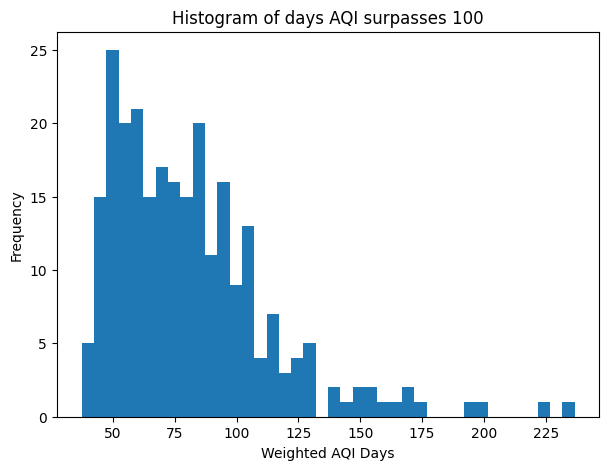

In [14]:
# plot histogram of number of days over 100
plt.figure(figsize=(7, 5))
plt.hist(df_air_by_county['Weighted AQI Days'], bins=40)
plt.xlabel('Weighted AQI Days')
plt.ylabel('Frequency')
plt.title('Histogram of days AQI surpasses 100')
plt.show()


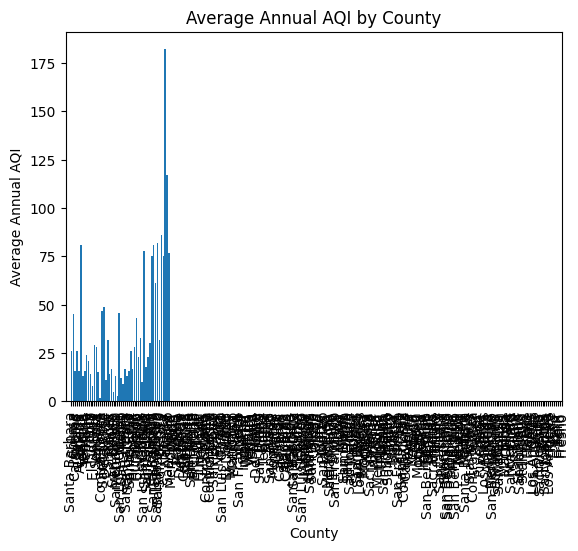

In [14]:
# Bar plot of AQI by county
import matplotlib.pyplot as plt
# plt.bar(df_air_by_county['CountyName'], df_air_by_county['AverageAnnualAQI'])
# plt.xticks(range(df_air_by_county['CountyName'].shape[0]), df_air_by_county['CountyName'], rotation='vertical')
# plt.show()

df_air_by_county_sorted = df_air_by_county.sort_values(by='days over 100', ascending=True)

plt.bar(df_air_by_county_sorted['CountyName'], df_air_by_county_sorted['days over 100'])
plt.xticks(range(df_air_by_county_sorted['CountyName'].shape[0]), df_air_by_county_sorted['CountyName'], rotation='vertical')
plt.xlabel('County')
plt.ylabel('Average Annual AQI')
plt.title('Average Annual AQI by County')
plt.show()


<Axes: xlabel='CountyName', ylabel='days over 100'>

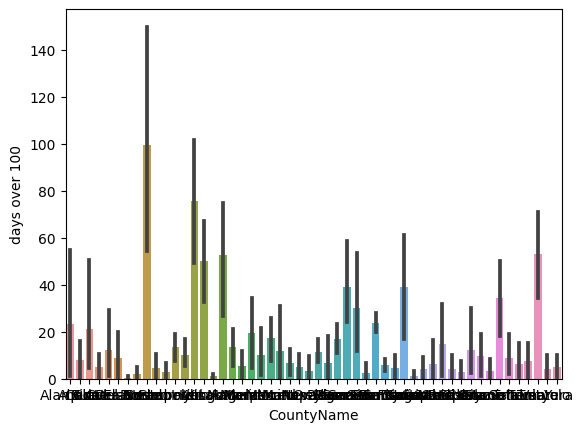

In [15]:
# Bar plot of AQI by county
# seaborn.barplot(data = df_air_by_county, x="CountyName", y="AverageAnnualAQI")
seaborn.barplot(data = df_air_by_county, x="CountyName", y="days over 100")

In [16]:
df_hospital_pop_bycounty = df_hospital_pop_bycounty.rename(columns={"YEAR": "Year"})
df_hospital_pop_bycounty.head(n=10)

,CountyName,Population,Year,VisitRate,YearCounty
0,Alameda,1682353,2015,64.3,2015 - Alameda
1,Alameda,1682353,2016,57.8,2016 - Alameda
2,Alameda,1682353,2017,56.3,2017 - Alameda
3,Alameda,1682353,2018,48.6,2018 - Alameda
4,Alameda,1682353,2019,45.8,2019 - Alameda
10,Amador,40474,2015,58.4,2015 - Amador
11,Amador,40474,2016,61.8,2016 - Amador
12,Amador,40474,2017,56.8,2017 - Amador
13,Amador,40474,2018,44.3,2018 - Amador
14,Amador,40474,2019,53.2,2019 - Amador


In [17]:
df_air_by_county["Year"] = df_air_by_county["Year"].astype("int64")
df_air_by_county.head()

,CountyName,Year,days over 100
0,Alameda,2015,5
1,Alpine,2015,16
2,Butte,2015,6
3,Calaveras,2015,4
4,Colusa,2015,6


In [18]:
# cleanup for merging

df_hospital_pop_bycounty.rename(columns={'YEAR': 'Year'}, inplace=True)
df_air_by_county['Year'] = df_air_by_county['Year'].astype('int64')



In [19]:
# merge AQI and hospital data
df_hospital_aqi = pd.merge(df_hospital_pop_bycounty[["CountyName", "Year", "VisitRate"]], df_air_by_county, on=["Year", "CountyName"], how='inner')
print(len(df_hospital_aqi))
df_hospital_aqi.head(n=50)

255


,CountyName,Year,VisitRate,days over 100
0,Alameda,2015,64.3,5
1,Alameda,2016,57.8,0
2,Alameda,2017,56.3,31
3,Alameda,2018,48.6,81
4,Alameda,2019,45.8,0
5,Butte,2015,50.2,6
6,Butte,2016,38.1,3
7,Butte,2017,45.3,14
8,Butte,2018,42.2,78
9,Butte,2019,35.5,5


<Axes: xlabel='days over 100', ylabel='VisitRate'>

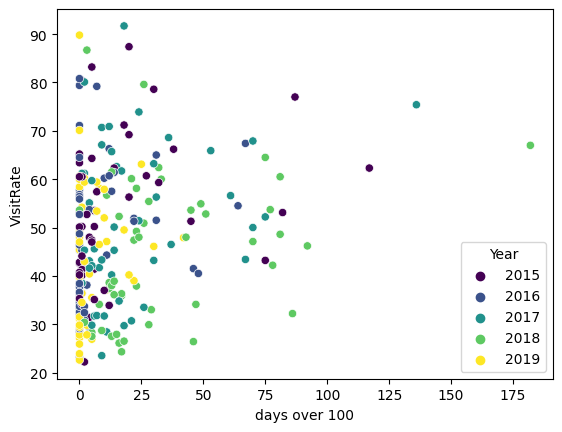

In [20]:
seaborn.scatterplot(data=df_hospital_aqi, x='days over 100', y='VisitRate', hue='Year', palette='viridis')

In [21]:
# plot Hospital Visits by AQI per county in 2021
# seaborn.scatterplot(data = df_hospital_aqi, x='AverageAnnualAQI', y='NormalizedVisits')

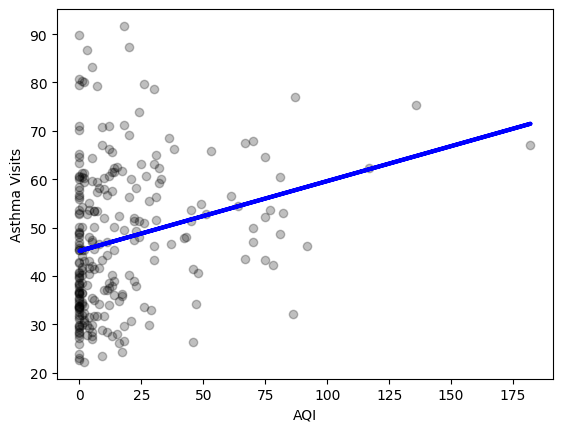

In [22]:
import statsmodels.api as sm

df_hospital_aqi = df_hospital_aqi.dropna(subset=['VisitRate', 'days over 100'])

x = df_hospital_aqi["days over 100"]
y = df_hospital_aqi["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(x, y,  color='black', alpha = 0.25)
plt.plot(x, y_pred, color='blue', linewidth=3)
plt.xlabel('AQI')
plt.ylabel('Asthma Visits')
plt.show()

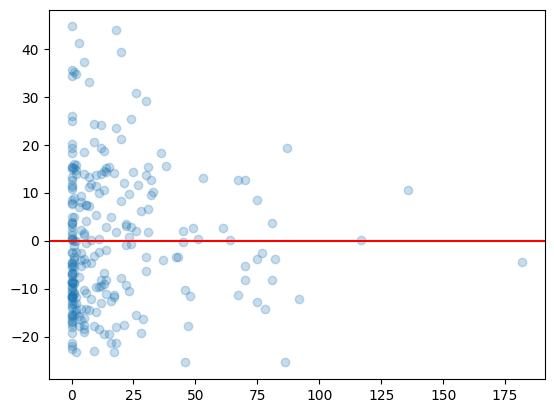

In [23]:
# Enter code here to plot the residuals (Question 7a)
residuals = y - y_pred
plt.scatter(x, residuals, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.show()

In [24]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     16.00
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           8.31e-05
Time:                        11:30:01   Log-Likelihood:                -1043.7
No. Observations:                 255   AIC:                             2091.
Df Residuals:                     253   BIC:                             2098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            45.1524      1.086     41.586

In [25]:
df_poverty = pd.read_csv('HDPulse_data_export.csv')
df_poverty = df_poverty[["County", "Value (Percent)"]]
df_poverty[">= 10%"] = df_poverty["Value (Percent)"] >= 10.0
df_poverty = df_poverty[~df_poverty["County"].isin(["United States", "California"])]
df_poverty.reset_index(drop=True, inplace=True)
df_poverty[">= 10%"] = df_poverty[">= 10%"].astype(int)
df_poverty = df_poverty.rename(columns={"County" : "CountyName"})
df_poverty["CountyName"] = df_poverty["CountyName"].str.replace(" County", "", regex=False)

In [26]:
df_hospital_aqi_poverty = pd.merge(df_poverty[["CountyName", ">= 10%"]], df_hospital_aqi, on=["CountyName"])
print(len(df_hospital_aqi_poverty))
df_hospital_aqi_poverty.head()

255


,CountyName,>= 10%,Year,VisitRate,days over 100
0,Imperial,1,2015,71.2,18
1,Imperial,1,2016,66.3,12
2,Imperial,1,2017,65.7,13
3,Imperial,1,2018,58.1,23
4,Imperial,1,2019,60.2,2


In [27]:
df_hospital_aqi_heat = pd.merge(df_hospital_aqi[["CountyName", "Year", "VisitRate", "days over 100"]], heat_index_counts, on=["Year", "CountyName"], how='inner')

NameError: name 'heat_index_counts' is not defined

In [ ]:
poverty_county_data = df_hospital_aqi_poverty[df_hospital_aqi_poverty[">= 10%"] == True]
not_poverty_county_data = df_hospital_aqi_poverty[df_hospital_aqi_poverty[">= 10%"] == False]

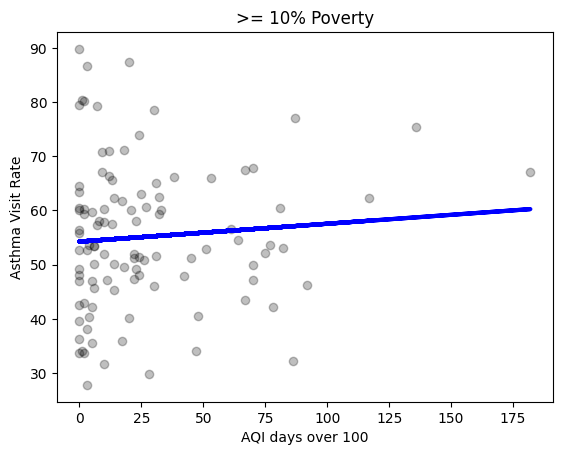

In [ ]:
# linear regression on >= 10% poverty 
x_pov = poverty_county_data["days over 100"]
y_pov = poverty_county_data["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_pov = sm.add_constant(x_pov)

# Fit the simple linear regression
sm_model_pov = sm.OLS(y_pov, x2_pov)
results_pov = sm_model_pov.fit()

# Make predictions using the linear regression
y_pred_pov = results_dis.predict(x2_pov)

# Plot 
plt.scatter(x_pov, y_pov,  color='black', alpha = 0.25)
plt.plot(x_pov, y_pred_pov, color='blue', linewidth=3)
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visit Rate')
plt.title('>= 10% Poverty')
plt.show()

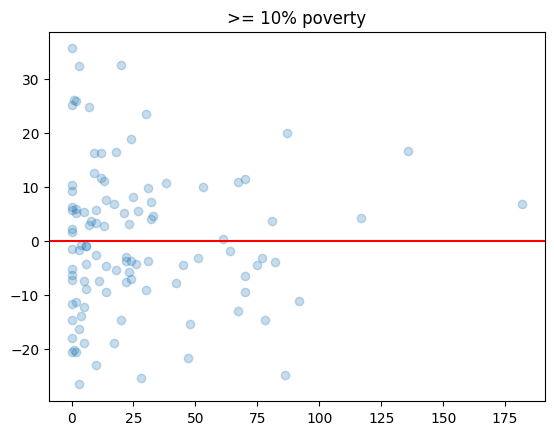

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6722
Date:                Tue, 03 Dec 2024   Prob (F-statistic):              0.414
Time:                        11:15:39   Log-Likelihood:                -420.39
No. Observations:                 105   AIC:                             844.8
Df Residuals:                     103   BIC:                             850.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            54.2489      1.685     32.186

In [ ]:
residuals_pov = y_pov - y_pred_pov
plt.scatter(x_pov, residuals_pov, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.title(">= 10% poverty")
plt.show()

print(results_pov.summary())

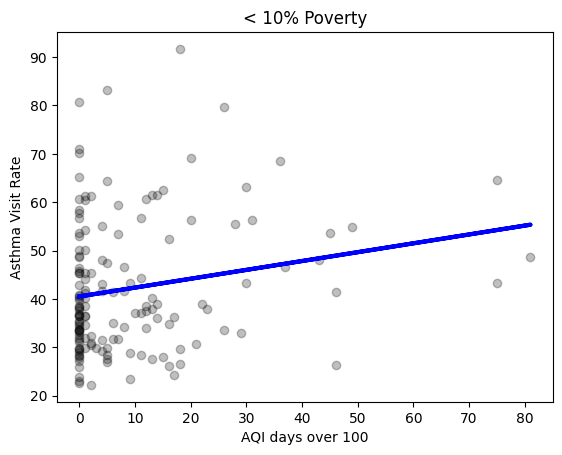

In [ ]:
# linear regression on < 10% poverty 
x_no_pov = not_poverty_county_data["days over 100"]
y_no_pov = not_poverty_county_data["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_no_pov = sm.add_constant(x_no_pov)

# Fit the simple linear regression
sm_model_no_pov = sm.OLS(y_no_pov, x2_no_pov)
results_no_pov= sm_model_no_pov.fit()

# Make predictions using the linear regression
y_pred_no_pov = results_no_pov.predict(x2_no_pov)

# Plot 
plt.scatter(x_no_pov, y_no_pov,  color='black', alpha = 0.25)
plt.plot(x_no_pov, y_pred_no_pov, color='blue', linewidth=3)
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visit Rate')
plt.title('< 10% Poverty')
plt.show()

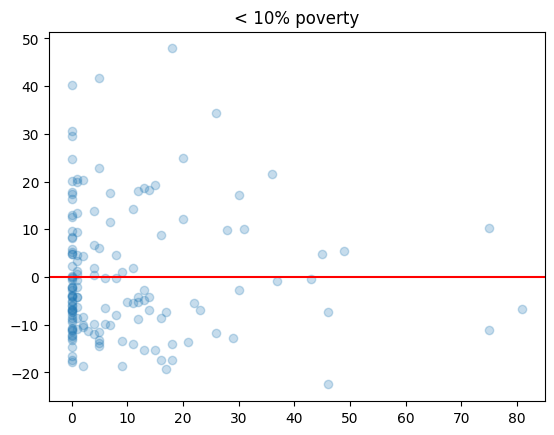

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.980
Date:                Tue, 03 Dec 2024   Prob (F-statistic):             0.0156
Time:                        11:15:39   Log-Likelihood:                -602.23
No. Observations:                 150   AIC:                             1208.
Df Residuals:                     148   BIC:                             1214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            40.5022      1.300     31.158

In [ ]:
residuals_no_pov = y_no_pov - y_pred_no_pov
plt.scatter(x_no_pov, residuals_no_pov, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.title("< 10% poverty")
plt.show()

print(results_no_pov.summary())

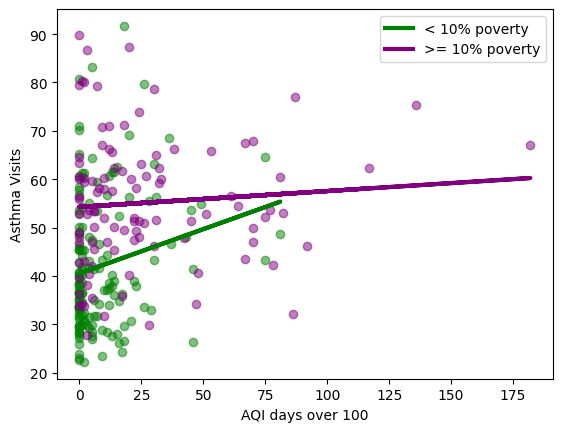

In [ ]:
plt.plot(x_no_pov, y_pred_no_pov, color='green', linewidth=3, label="< 10% poverty")
plt.scatter(x_no_pov, y_no_pov, color='green', alpha=0.5)
plt.plot(x_pov, y_pred_pov, color='purple', linewidth=3, label=">= 10% poverty")
plt.scatter(x_pov, y_pov, color='purple', alpha=0.5)
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visits')
plt.legend()
plt.show()

In [ ]:
# import cjest
df_cjest = pd.read_csv('1.0-communities.csv', low_memory=False)
df_cjest = df_cjest[df_cjest['State/Territory'] == 'California']
# Select only the desired columns
df_cjest = df_cjest[['Census tract 2010 ID', 
                     'County Name', 
                     'State/Territory', 
                     'Percent Black or African American alone', 
                     'Percent American Indian / Alaska Native', 
                     'Percent Asian', 
                     'Percent Native Hawaiian or Pacific', 
                     'Percent two or more races', 
                     'Percent White', 
                     'Percent Hispanic or Latino', 
                     'Percent other races', 
                     'Identified as disadvantaged', 
                     'Percentage of tract that is disadvantaged by area', 
                     'Total population', 
                     'Is low income?', 
                     'Adjusted percent of individuals below 200% Federal Poverty Line (percentile)', 
                     'Adjusted percent of individuals below 200% Federal Poverty Line']]

# Display the resulting dataframe
df_cjest.head()

,Census tract 2010 ID,County Name,State/Territory,Percent Black or African American alone,Percent American Indian / Alaska Native,Percent Asian,Percent Native Hawaiian or Pacific,Percent two or more races,Percent White,Percent Hispanic or Latino,Percent other races,Identified as disadvantaged,Percentage of tract that is disadvantaged by area,Total population,Is low income?,Adjusted percent of individuals below 200% Federal Poverty Line (percentile),Adjusted percent of individuals below 200% Federal Poverty Line
3560,6001400100,Alameda County,California,0.03,0.00,0.12,0.0,0.05,0.74,0.03,0.01,False,0,3120.0,False,0.08,0.01
3561,6001400200,Alameda County,California,0.02,0.00,0.08,0.0,0.09,0.73,0.08,0.00,False,0,2007.0,False,0.12,0.03
3562,6001400300,Alameda County,California,0.09,0.00,0.11,0.0,0.01,0.67,0.06,0.02,False,0,5051.0,False,0.09,0.02
3563,6001400400,Alameda County,California,0.07,0.01,0.10,0.0,0.07,0.63,0.12,0.04,False,0,4007.0,False,0.30,0.12
3564,6001400500,Alameda County,California,0.21,0.00,0.10,0.0,0.15,0.45,0.09,0.02,False,0,4124.0,False,0.23,0.09


In [ ]:
df_cjest["Disadvantaged Numeric"] = df_cjest["Identified as disadvantaged"].astype(int)
df_county_disadvantaged_status = (
    df_cjest.groupby("County Name")
    .apply(lambda group: (
        group["Disadvantaged Numeric"] * group["Total population"]
    ).sum() / group["Total population"].sum())
    .reset_index(name="Weighted Disadvantaged")
)
df_county_disadvantaged_status["County identified as disadvantaged"] = df_county_disadvantaged_status["Weighted Disadvantaged"] >= 0.5
df_county_disadvantaged_status = df_county_disadvantaged_status.rename(columns={"County Name": "CountyName"})
df_county_disadvantaged_status["CountyName"] = df_county_disadvantaged_status["CountyName"].str.replace(" County", "", regex=False).str.strip()
df_county_disadvantaged_status.head()

,CountyName,Weighted Disadvantaged,County identified as disadvantaged
0,Alameda,0.245741,False
1,Alpine,1.000000,True
2,Amador,0.051576,False
3,Butte,0.379024,False
4,Calaveras,0.224502,False


In [ ]:
df_hospital_aqi.head()

,CountyName,Year,VisitRate,days over 100
0,Alameda,2015,64.3,5
1,Alameda,2016,57.8,0
2,Alameda,2017,56.3,31
3,Alameda,2018,48.6,81
4,Alameda,2019,45.8,0


In [ ]:
# merge in disadvantaged column to existing dataframe
df_hospital_aqi_disadvant = pd.merge(df_county_disadvantaged_status[["CountyName", "County identified as disadvantaged"]], df_hospital_aqi, on=["CountyName"])
print(len(df_hospital_aqi_disadvant))
df_hospital_aqi_disadvant.head()

255


,CountyName,County identified as disadvantaged,Year,VisitRate,days over 100
0,Alameda,False,2015,64.3,5
1,Alameda,False,2016,57.8,0
2,Alameda,False,2017,56.3,31
3,Alameda,False,2018,48.6,81
4,Alameda,False,2019,45.8,0


In [ ]:
# divide based on disadvantaged or not

disadvantaged_county_data = df_hospital_aqi_disadvant[df_hospital_aqi_disadvant["County identified as disadvantaged"] == True]
not_disadvantaged_county_data = df_hospital_aqi_disadvant[df_hospital_aqi_disadvant["County identified as disadvantaged"] == False]

print(disadvantaged_county_data.head())
print(not_disadvantaged_county_data.head())

   CountyName  County identified as disadvantaged  Year  VisitRate  \
15     Colusa                                True  2015       41.4   
16     Colusa                                True  2016       29.6   
17     Colusa                                True  2017       28.4   
18     Colusa                                True  2018       53.6   
19     Colusa                                True  2019       45.4   

    days over 100  
15              6  
16              0  
17             11  
18             45  
19              0  
  CountyName  County identified as disadvantaged  Year  VisitRate  \
0    Alameda                               False  2015       64.3   
1    Alameda                               False  2016       57.8   
2    Alameda                               False  2017       56.3   
3    Alameda                               False  2018       48.6   
4    Alameda                               False  2019       45.8   

   days over 100  
0              5  
1     

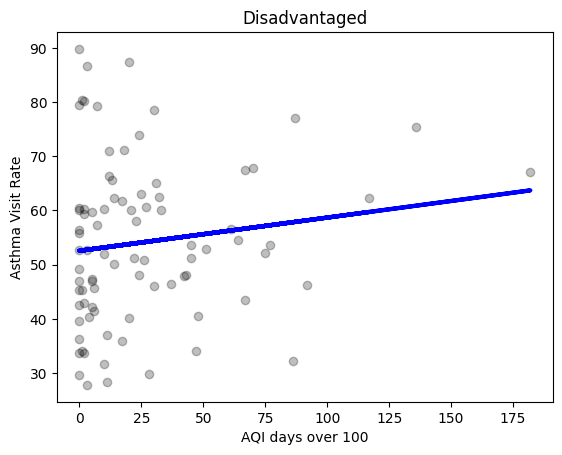

In [ ]:
# run linear regression on disadvantaged counties

x_dis = disadvantaged_county_data["days over 100"]
y_dis = disadvantaged_county_data["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_dis = sm.add_constant(x_dis)

# Fit the simple linear regression
sm_model_dis = sm.OLS(y_dis, x2_dis)
results_dis = sm_model_dis.fit()

# Make predictions using the linear regression
y_pred_dis = results_dis.predict(x2_dis)

# Plot 
plt.scatter(x_dis, y_dis,  color='black', alpha = 0.25)
plt.plot(x_dis, y_pred_dis, color='blue', linewidth=3)
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visit Rate')
plt.title('Disadvantaged')
plt.show()

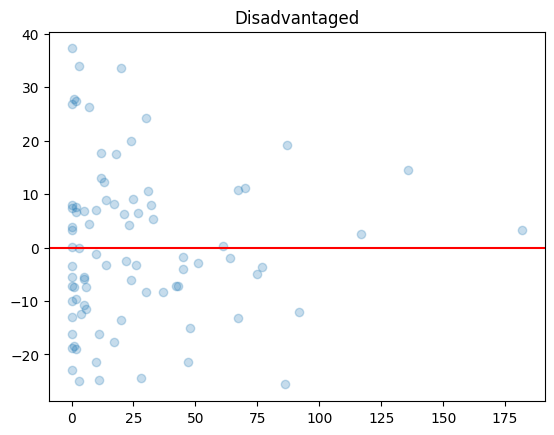

In [ ]:
residuals_dis = y_dis - y_pred_dis
plt.scatter(x_dis, residuals_dis, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.title("Disadvantaged")
plt.show()

In [ ]:
print(results_dis.summary())

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.628
Date:                Tue, 03 Dec 2024   Prob (F-statistic):              0.206
Time:                        11:15:40   Log-Likelihood:                -348.70
No. Observations:                  85   AIC:                             701.4
Df Residuals:                      83   BIC:                             706.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            52.5502      2.030     25.891

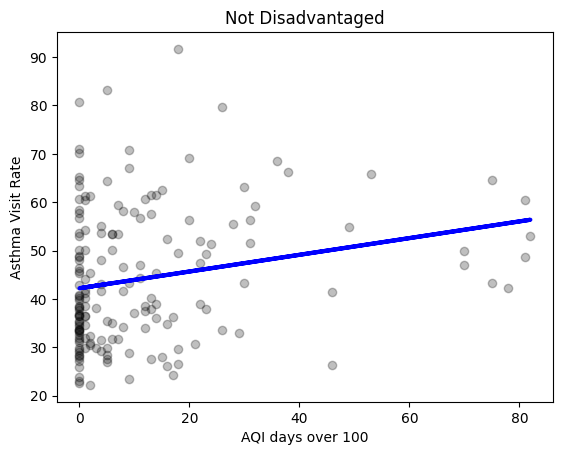

In [ ]:
# not disadvantaged

x_no_dis = not_disadvantaged_county_data["days over 100"]
y_no_dis = not_disadvantaged_county_data["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_no_dis = sm.add_constant(x_no_dis)

# Fit the simple linear regression
sm_model_no_dis = sm.OLS(y_no_dis, x2_no_dis)
results_no_dis = sm_model_no_dis.fit()

# Make predictions using the linear regression
y_pred_no_dis = results_no_dis.predict(x2_no_dis)

# Plot 
plt.scatter(x_no_dis, y_no_dis,  color='black', alpha = 0.25)
plt.plot(x_no_dis, y_pred_no_dis, color='blue', linewidth=3)
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visit Rate')
plt.title('Not Disadvantaged')
plt.show()

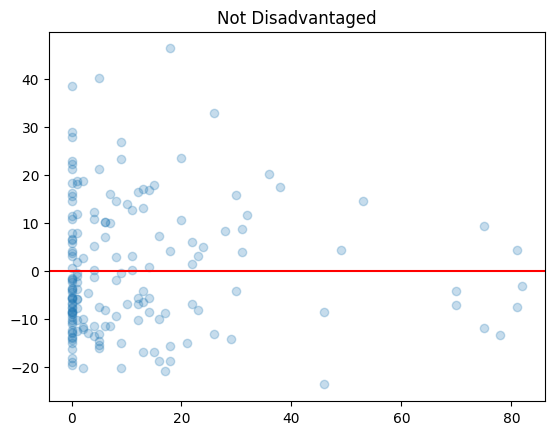

In [ ]:
residuals_no_dis = y_no_dis - y_pred_no_dis
plt.scatter(x_no_dis, residuals_no_dis, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.title("Not Disadvantaged")
plt.show()

In [ ]:
print(results_no_dis.summary())

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     8.940
Date:                Tue, 03 Dec 2024   Prob (F-statistic):            0.00321
Time:                        11:15:40   Log-Likelihood:                -684.18
No. Observations:                 170   AIC:                             1372.
Df Residuals:                     168   BIC:                             1379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            42.2030      1.241     34.020

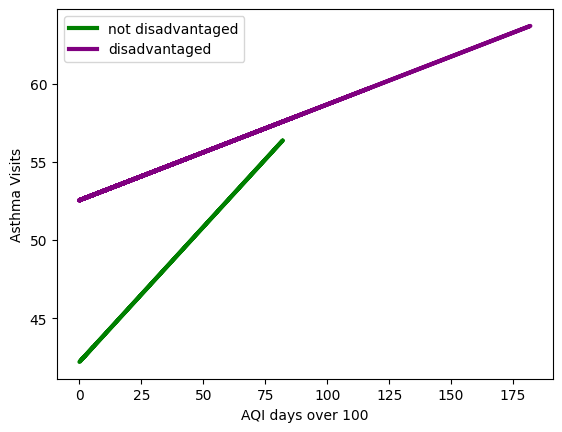

In [ ]:
plt.plot(x_no_dis, y_pred_no_dis, color='green', linewidth=3, label="not disadvantaged")
plt.plot(x_dis, y_pred_dis, color='purple', linewidth=3, label="disadvantaged")
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visits')
plt.legend()
plt.show()

<Axes: xlabel='CountyName', ylabel='days over 100'>

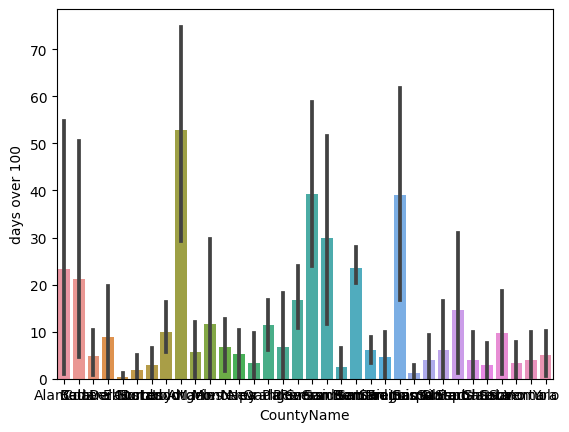

In [ ]:
seaborn.barplot(data = not_disadvantaged_county_data, x="CountyName", y="days over 100")

<Axes: xlabel='CountyName', ylabel='days over 100'>

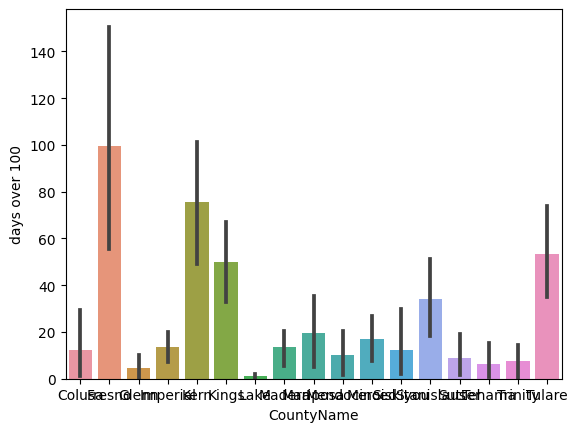

In [ ]:
seaborn.barplot(data = disadvantaged_county_data, x="CountyName", y="days over 100")

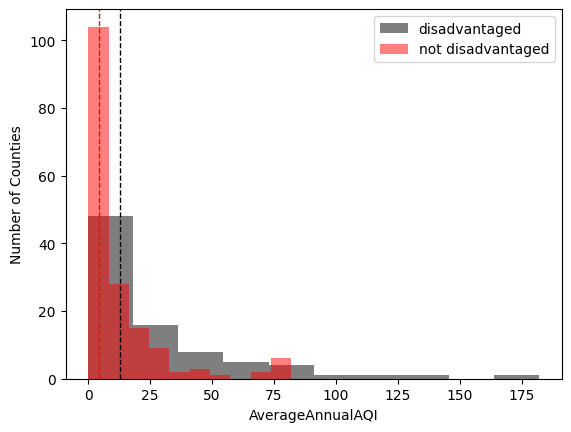

In [ ]:
plt.hist(disadvantaged_county_data['days over 100'], 
         alpha=0.5, # the transaparency parameter
         color='black',
         label='disadvantaged')
  
plt.hist(not_disadvantaged_county_data['days over 100'],
         alpha=0.5,
         color = 'red',
         label='not disadvantaged')

plt.axvline(disadvantaged_county_data['days over 100'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(not_disadvantaged_county_data['days over 100'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('AverageAnnualAQI')
plt.ylabel('Number of Counties')
plt.show()

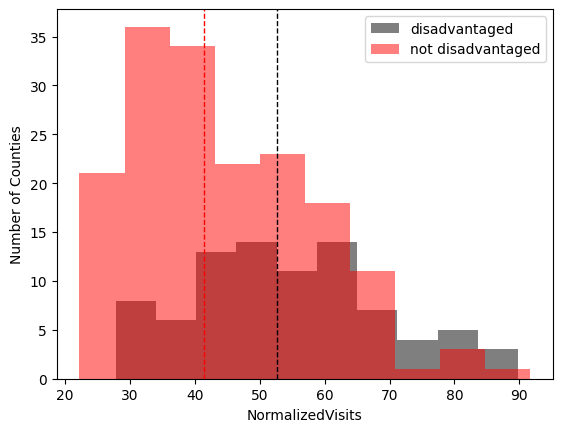

In [ ]:
plt.hist(disadvantaged_county_data['VisitRate'], 
         alpha=0.5, # the transaparency parameter
         color='black',
         label='disadvantaged')
  
plt.hist(not_disadvantaged_county_data['VisitRate'],
         alpha=0.5,
         color = 'red',
         label='not disadvantaged')

plt.axvline(disadvantaged_county_data['VisitRate'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(not_disadvantaged_county_data['VisitRate'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()

In [ ]:
from scipy.stats import median_test
stat, p, med, tbl = median_test(disadvantaged_county_data['VisitRate'], not_disadvantaged_county_data['VisitRate'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
if (p < 0.01):
        print("There IS a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for Asthma Hospital Visits")
else: 
        print("There is NOT a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for Asthma Hospital Visits")

The p-value for the Moods Median test is  5.587690331978727e-05
The grand median (median for all both samples together) is  46.2
The contingency table is: 
 [[ 58  69]
 [ 27 101]]
There IS a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for Asthma Hospital Visits


In [ ]:
from scipy.stats import median_test
stat, p, med, tbl = median_test(disadvantaged_county_data['days over 100'], not_disadvantaged_county_data['days over 100'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
if (p < 0.01):
        print("There IS a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for AQI")
else: 
        print("There is NOT a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for AQI")

The p-value for the Moods Median test is  0.008973389799690848
The grand median (median for all both samples together) is  6.0
The contingency table is: 
 [[52 73]
 [33 97]]
There IS a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for AQI


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


aqi_data = pd.read_csv('air_quality_2021.csv')

CA_geo = gpd.read_file('tl_2019_06_cousub.shp')
CA_geo.crs = "EPSG:4326"

CA_geo = CA_geo.merge(aqi_data, left_on='COUNTY_NAME', right_on='County')

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)


CA_geo.plot(column='AQI', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)

ax.set_title('California Air Quality Index (AQI) by County - 2021', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()

plt.show()


DataSourceError: Invalid length for entity 3

In [ ]:
# file_path = 'data_meteorolgy.csv'  # File name provided
# df = pd.read_csv(file_path)

# # Convert the 'Date' column to datetime format if it's not already
# df['Date'] = pd.to_datetime(df['Date'])

# # Extract the year from the 'Date' column
# df['Year'] = df['Date'].dt.year

# # County and corresponding station map
# county_station_map = {
#     "Fresno": [2, 7, 39, 80, 105, 124, 205],
#     "Kern": [5, 125, 146, 257],
#     "Yolo": [6, 226],
#     "Butte": [12, 244],
#     "El Dorado": [13, 228],
#     "Kings": [15],
#     "Inyo": [35, 183],
#     "Imperial": [41, 68, 87, 175, 181],
#     "Shasta": [43, 224],
#     "Riverside": [44, 62, 135, 136, 151, 179, 200, 208, 218, 237, 239, 240],
#     "Contra Costa": [47, 170, 178, 213, 247],
#     "San Luis Obispo": [52, 160, 163, 202, 265, 266],
#     "Santa Barbara": [64, 88, 107, 165, 231, 232],
#     "San Joaquin": [70, 242, 248, 249, 262],
#     "Stanislaus": [71, 194, 206],
#     "Orange": [75, 241, 245],
#     "Napa": [77],
#     "Los Angeles": [78, 99, 159, 174, 197, 204, 215, 216, 219, 220, 223],
#     "Sonoma": [103, 144, 158, 83],
#     "Yuba": [84],
#     "Modoc": [90],
#     "Siskiyou": [91, 225, 236, 260, 261],
#     "Santa Cruz": [104, 209],
#     "Mendocino": [106],
#     "Monterey": [113, 114, 116, 129, 193, 210, 214, 229, 252],
#     "San Bernardino": [117, 192, 199, 221, 233, 251],
#     "San Benito": [126, 143],
#     "Sacramento": [131, 140, 243],
#     "San Diego": [147, 150, 153, 173, 184, 207],
#     "Ventura": [152, 217],
#     "Marin": [157, 187],
#     "Tulare": [258, 182],
#     "Alameda": [191, 254, 171],
#     "Placer": [195],
#     "Santa Clara": [211],
#     "Tehama": [222],
#     "Amador": [227],
#     "Sutter": [235],
#     "Alpine": [246],
#     "Colusa": [250],
#     "San Mateo": [253],
#     "Humboldt": [259],
#     "Del Norte": [263],
#     "Plumas": [264],
#     "Lassen": [267, 268],
#     "Solano": [139, 212]
# }

# # Create a new DataFrame for county-level maximum averages
# county_averages = []

# # Iterate over each county and its corresponding stations
# for county, stations in county_station_map.items():
#     # Filter data for the specific stations
#     county_data = df[df['Stn Id'].isin(stations)]
    
#     # Group the data by year and calculate the averages
#     for year, group in county_data.groupby('Year'):
#         avg_row = {
#             "CountyName": county,
#             "Year": year,
#             "Avg Max Air Temp (F)": group["Max Air Temp (F)"].mean(),
#             "Avg Max Rel Hum (%)": group["Max Rel Hum (%)"].mean()
#         }
#         county_averages.append(avg_row)

# # Convert the list of averages to a DataFrame
# county_df = pd.DataFrame(county_averages)

# # Save the county averages to a new CSV file
# output_file = 'county_max_averages.csv'
# county_df.to_csv(output_file, index=False)

# df['Year'] = df['Date'].dt.year

# # Iterate over each county and its corresponding stations
# for county, stations in county_station_map.items():
#     # Filter data for the specific stations
#     county_data = df[df['Stn Id'].isin(stations)]
    
#     # Group the data by year and calculate the averages
#     for year, group in county_data.groupby('Year'):
#         avg_row = {
#             "CountyName": county,
#             "Year": year,
#             "Avg Max Air Temp (F)": group["Max Air Temp (F)"].mean(),
#             "Avg Max Rel Hum (%)": group["Max Rel Hum (%)"].mean()
#         }
#         county_averages.append(avg_row)



In [ ]:
file_path = 'data_meteorolgy.csv'  # File name provided
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from the 'Date' column
df['Year'] = df['Date'].dt.year

# County and corresponding station map
county_station_map = {
    "Fresno": [2, 7, 39, 80, 105, 124, 205],
    "Kern": [5, 125, 146, 257],
    "Yolo": [6, 226],
    "Butte": [12, 244],
    "El Dorado": [13, 228],
    "Kings": [15],
    "Inyo": [35, 183],
    "Imperial": [41, 68, 87, 175, 181],
    "Shasta": [43, 224],
    "Riverside": [44, 62, 135, 136, 151, 179, 200, 208, 218, 237, 239, 240],
    "Contra Costa": [47, 170, 178, 213, 247],
    "San Luis Obispo": [52, 160, 163, 202, 265, 266],
    "Santa Barbara": [64, 88, 107, 165, 231, 232],
    "San Joaquin": [70, 242, 248, 249, 262],
    "Stanislaus": [71, 194, 206],
    "Orange": [75, 241, 245],
    "Napa": [77],
    "Los Angeles": [78, 99, 159, 174, 197, 204, 215, 216, 219, 220, 223],
    "Sonoma": [103, 144, 158, 83],
    "Yuba": [84],
    "Modoc": [90],
    "Siskiyou": [91, 225, 236, 260, 261],
    "Santa Cruz": [104, 209],
    "Mendocino": [106],
    "Monterey": [113, 114, 116, 129, 193, 210, 214, 229, 252],
    "San Bernardino": [117, 192, 199, 221, 233, 251],
    "San Benito": [126, 143],
    "Sacramento": [131, 140, 243],
    "San Diego": [147, 150, 153, 173, 184, 207],
    "Ventura": [152, 217],
    "Marin": [157, 187],
    "Tulare": [258, 182],
    "Alameda": [191, 254, 171],
    "Placer": [195],
    "Santa Clara": [211],
    "Tehama": [222],
    "Amador": [227],
    "Sutter": [235],
    "Alpine": [246],
    "Colusa": [250],
    "San Mateo": [253],
    "Humboldt": [259],
    "Del Norte": [263],
    "Plumas": [264],
    "Lassen": [267, 268],
    "Solano": [139, 212]
}

# Create a new DataFrame for county-level maximum averages
county_averages = []

# Iterate over each county and its corresponding stations
for county, stations in county_station_map.items():
    # Filter data for the specific stations
    county_data = df[df['Stn Id'].isin(stations)]
#     print(county_data)
    
    # Group the data by year and calculate the averages
    for date, group in county_data.groupby('Date'):
        avg_row = {
            "CountyName": county,
            "Date": date,
            "Avg Max Air Temp (F)": group["Max Air Temp (F)"].mean(),
            "Avg Max Rel Hum (%)": group["Max Rel Hum (%)"].mean()
        }
        county_averages.append(avg_row)

# Convert the list of averages to a DataFrame
county_df = pd.DataFrame(county_averages)

# county_df[county_df["CountyName"] == "Yolo"]

# # Save the county averages to a new CSV file
output_file = 'county_max_averages_daily.csv'
county_df.to_csv(output_file, index=False)



In [ ]:
# Load the dataset
df_meteor = pd.read_csv('county_max_averages_daily.csv')

# Heat index calculation using the simplified formula
df_meteor['Heat Index'] = (0.5 * (
    df_meteor['Avg Max Air Temp (F)'] + 61 +
    ((df_meteor['Avg Max Air Temp (F)'] - 68) * 1.2) +
    (df_meteor['Avg Max Rel Hum (%)'] * 0.094)
) + df_meteor['Avg Max Air Temp (F)']) / 2

# Heat index calculation using the Rothfusz regression equation for HI > 80
df_meteor.loc[
    df_meteor['Heat Index'] > 80, 'Heat Index'
] = -42.379 + 2.04901523 * df_meteor['Avg Max Air Temp (F)'] + \
    10.14333127 * df_meteor['Avg Max Rel Hum (%)'] - \
    0.22475541 * df_meteor['Avg Max Air Temp (F)'] * df_meteor['Avg Max Rel Hum (%)'] - \
    0.00683783 * df_meteor['Avg Max Air Temp (F)']**2 - \
    0.05481717 * df_meteor['Avg Max Rel Hum (%)']**2 + \
    0.00122874 * df_meteor['Avg Max Rel Hum (%)'] * df_meteor['Avg Max Air Temp (F)']**2 + \
    0.00085282 * df_meteor['Avg Max Air Temp (F)'] * df_meteor['Avg Max Rel Hum (%)']**2 - \
    0.00000199 * (df_meteor['Avg Max Air Temp (F)']**2) * df_meteor['Avg Max Rel Hum (%)']**2

# Adjustment for RH < 13 and 80 < T < 112
df_meteor.loc[
    (df_meteor['Avg Max Rel Hum (%)'] < 13) &
    (df_meteor['Avg Max Air Temp (F)'] > 80) &
    (df_meteor['Avg Max Air Temp (F)'] < 112),
    'Heat Index'
] -= ((13 - df_meteor['Avg Max Rel Hum (%)']) / 4) * np.sqrt(
    (17 - np.abs(df_meteor['Avg Max Air Temp (F)'] - 95)) / 17
)

# Adjustment for RH > 85 and 80 < T < 87
df_meteor.loc[
    (df_meteor['Avg Max Rel Hum (%)'] > 85) &
    (df_meteor['Avg Max Air Temp (F)'] > 80) &
    (df_meteor['Avg Max Air Temp (F)'] < 87),
    'Heat Index'
] += ((df_meteor['Avg Max Rel Hum (%)'] - 85) / 10) * \
    ((87 - df_meteor['Avg Max Air Temp (F)']) / 5)

# Display the first few rows of the updated dataframe
df_meteor['Year'] = pd.to_datetime(df_meteor['Date']).dt.year
df_meteor.head(n=10)


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CountyName,Date,Avg Max Air Temp (F),Avg Max Rel Hum (%),Heat Index,Year
0,Fresno,2015-01-01,53.228571,93.285714,52.932214,2015
1,Fresno,2015-01-02,52.628571,90.714286,52.241786,2015
2,Fresno,2015-01-03,55.571429,91.142857,55.341857,2015
3,Fresno,2015-01-04,56.214286,91.857143,56.033643,2015
4,Fresno,2015-01-05,60.271429,92.000000,60.297000,2015
5,Fresno,2015-01-06,64.357143,92.571429,64.600429,2015
6,Fresno,2015-01-07,66.457143,93.000000,66.815500,2015
7,Fresno,2015-01-08,65.357143,93.857143,65.680643,2015
8,Fresno,2015-01-09,64.042857,93.000000,64.280500,2015
9,Fresno,2015-01-10,65.728571,93.571429,66.063929,2015


In [ ]:
df_meteor = df_meteor[["CountyName", "Heat Index", "Year"]]
df_filtered = df_meteor[df_meteor['Heat Index'] > 80]
heat_index_counts = df_filtered.groupby(['CountyName', 'Year']).size().reset_index(name='WarningHeatDays')
heat_index_counts

,CountyName,Year,WarningHeatDays
0,Alameda,2015,101
1,Alameda,2016,94
2,Alameda,2017,125
3,Alameda,2018,65
4,Alameda,2019,74
...,...,...,...
202,Yuba,2015,159
203,Yuba,2016,138
204,Yuba,2017,142
205,Yuba,2018,146


187
                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     24.95
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           2.59e-10
Time:                        11:22:56   Log-Likelihood:                -742.76
No. Observations:                 187   AIC:                             1492.
Df Residuals:                     184   BIC:                             1501.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              30.0167      2.815 

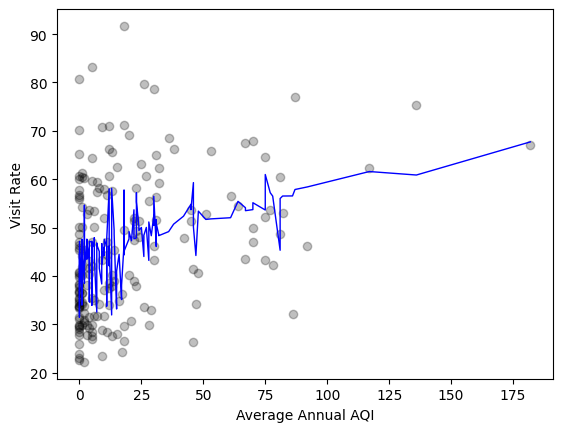

In [ ]:
df_hospital_aqi_heat = pd.merge(df_hospital_aqi[["CountyName", "Year", "VisitRate", "days over 100"]], heat_index_counts, on=["Year", "CountyName"], how='inner')
print(len(df_hospital_aqi_heat))

df_hospital_aqi_heat = df_hospital_aqi_heat.sort_values(by="days over 100")

x = df_hospital_aqi_heat[["WarningHeatDays", "days over 100"]]
y = df_hospital_aqi_heat["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()
print(results.summary())

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(df_hospital_aqi_heat["days over 100"], y, color='black', alpha=0.25)
plt.plot(df_hospital_aqi_heat["days over 100"], y_pred, color='blue', linewidth=1)
plt.xlabel('Average Annual AQI')
plt.ylabel('Visit Rate')
plt.show()

# Repeat for Heat Index
# plt.scatter(df_hospital_aqi_heat["WarningHeatDays"], y, color='black', alpha=0.25)
# plt.plot(df_hospital_aqi_heat["WarningHeatDays"], y_pred, color='blue', linewidth=1)
# plt.xlabel('WarningHeatDays')
# plt.ylabel('Visit Rate')
# plt.show()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Calculate residuals



187
                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     24.95
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           2.59e-10
Time:                        11:23:17   Log-Likelihood:                -742.76
No. Observations:                 187   AIC:                             1492.
Df Residuals:                     184   BIC:                             1501.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              30.0167      2.815 

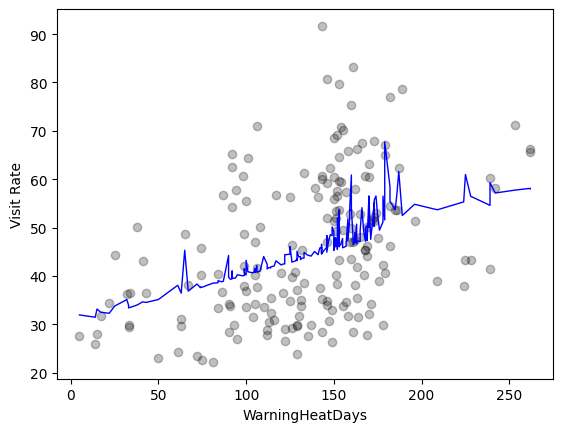

In [ ]:
df_hospital_aqi_heat = pd.merge(df_hospital_aqi[["CountyName", "Year", "VisitRate", "days over 100"]], heat_index_counts, on=["Year", "CountyName"], how='inner')
print(len(df_hospital_aqi_heat))

df_hospital_aqi_heat = df_hospital_aqi_heat.sort_values(by="WarningHeatDays")

x = df_hospital_aqi_heat[["WarningHeatDays", "days over 100"]]
y = df_hospital_aqi_heat["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()
print(results.summary())

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
# plt.scatter(df_hospital_aqi_heat["days over 100"], y, color='black', alpha=0.25)
# plt.plot(df_hospital_aqi_heat["days over 100"], y_pred, color='blue', linewidth=1)
# plt.xlabel('Average Annual AQI')
# plt.ylabel('Visit Rate')
# plt.show()

# Repeat for Heat Index
plt.scatter(df_hospital_aqi_heat["WarningHeatDays"], y, color='black', alpha=0.25)
plt.plot(df_hospital_aqi_heat["WarningHeatDays"], y_pred, color='blue', linewidth=1)
plt.xlabel('WarningHeatDays')
plt.ylabel('Visit Rate')
plt.show()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Calculate residuals

In [ ]:
#Shapiro Wilks Test

residuals = y - y_pred

# Perform the Shapiro-Wilk test on residuals
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)

# Print the results
print("Shapiro-Wilk Test Statistic:", stat)
print("p-value:", p_value)

# Interpret the results
if p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

Shapiro-Wilk Test Statistic: 0.9762662649154663
p-value: 0.0027468157932162285
Residuals do not appear to be normally distributed (reject H0).


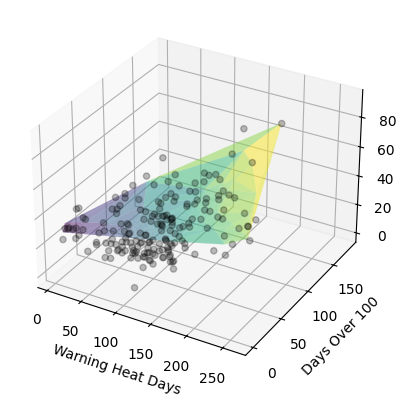

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Prepare the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data points
ax.scatter(df_hospital_aqi_heat["WarningHeatDays"], df_hospital_aqi_heat["days over 100"], y, color='black', alpha=0.25)

# Plot the prediction surface
ax.plot_trisurf(df_hospital_aqi_heat["WarningHeatDays"], df_hospital_aqi_heat["days over 100"], y_pred, cmap='viridis', linewidth=0, alpha=0.5)

# Set labels
ax.set_xlabel('Warning Heat Days')
ax.set_ylabel('Days Over 100')
ax.set_zlabel('Normalized Visits')

plt.show()


/opt/homebrew/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


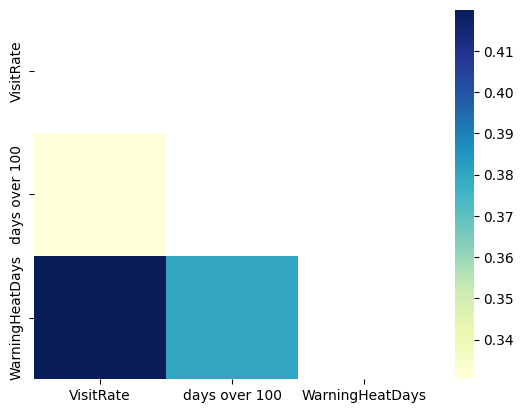

                 VisitRate  days over 100  WarningHeatDays
VisitRate          1.00000       0.330380         0.419970
days over 100      0.33038       1.000000         0.380404
WarningHeatDays    0.41997       0.380404         1.000000


In [ ]:
# test for correlation between heat and aqi 

df_corr = df_hospital_aqi_heat.drop(["CountyName",'Year'], axis = 1)

# Determine the correlations between the predictive variables
corr = df_corr.corr()
   
# The correlation matrix will have values of one along the diagonal (a predictive variable
# correlated to itself). Information above this diagonal is duplicated below the diagonal.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Construct a heatmap of the correlation matrix
# Note "annot = True" shows the correlation coefficient in each cell
seaborn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask, cmap="YlGnBu",
        annot=True,
        fmt=".1f")
plt.show()


In [ ]:
df_hospital_aqi_heat.head
df_meteor.head(n=10)

,CountyName,Date,Avg Max Air Temp (F),Avg Max Rel Hum (%),Heat Index,Year
0,Fresno,2015-01-01,53.228571,93.285714,52.932214,2015
1,Fresno,2015-01-02,52.628571,90.714286,52.241786,2015
2,Fresno,2015-01-03,55.571429,91.142857,55.341857,2015
3,Fresno,2015-01-04,56.214286,91.857143,56.033643,2015
4,Fresno,2015-01-05,60.271429,92.000000,60.297000,2015
5,Fresno,2015-01-06,64.357143,92.571429,64.600429,2015
6,Fresno,2015-01-07,66.457143,93.000000,66.815500,2015
7,Fresno,2015-01-08,65.357143,93.857143,65.680643,2015
8,Fresno,2015-01-09,64.042857,93.000000,64.280500,2015
9,Fresno,2015-01-10,65.728571,93.571429,66.063929,2015


In [ ]:
# make daily aqi df with flags 
def make_aqi_daily_df(csv_namer):
    df_air_daily = pd.read_csv(csv_name)
    df_air_daily['Date'] = pd.to_datetime(df_air_daily['Date'])
    return df_air_daily[['CountyName', 'Date','Daily AQI Value']]

make_aqi_daily_df('air_quality_2015.csv')
    

SyntaxError: unmatched ')' (674828830.py, line 2)